In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
import gym

In [2]:
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

transaction_cost = .001

In [73]:
daily_eth = pd.read_csv('../data/ETH-USD_hr_24.csv', sep=',')
#daily_eth["time"] = pd.to_datetime(daily_eth['time'], unit='s')

In [74]:
# assumption: make decision at open of trading period
# shift these cols
shift_header = ['low', 'high', 'open','close', 'volume']
for col in shift_header:
    new_header = f'last_{col}'
    daily_eth[new_header] = daily_eth[col].shift(1)

In [75]:
daily_eth = daily_eth.rename(columns={'open':'current_open', 'close':'target_close'})

In [76]:
# drop unnecessary col
drop_headers = ['low', 'high', 'volume']
daily_eth = daily_eth.drop(drop_headers, axis = 1)

In [77]:
# rearrange cols
daily_eth = daily_eth[['time', 'last_low', 'last_high', 'last_open','last_close','last_volume', 'current_open', 'target_close']]

In [78]:
def label_trade(diff):
    if(abs(diff) <= transaction_cost):
        return 0
    elif diff > transaction_cost:
        return 1
    else:
        return -1

In [79]:
daily_eth['target_return'] = (daily_eth['target_close'] - daily_eth['current_open']) / daily_eth['current_open']
daily_eth['target_trade'] = daily_eth['target_return'].apply(label_trade)


In [80]:
daily_eth['target_trade'].value_counts()

 1    389
-1    307
 0     16
Name: target_trade, dtype: int64

In [81]:
daily_eth.to_csv('labeled_daily_eth.csv', header=True, index=False, mode='w')

In [42]:
daily_eth['profit'] = daily_eth['target_return'] * daily_eth['target_trade'] * daily_eth['target_close']
daily_eth['profit'].sum()

40401.97124808046

In [ ]:
# drop first time period
daily_eth = daily_eth.dropna()

In [51]:
daily_eth['trade'].value_counts()

 1    389
-1    307
 0     16
Name: trade, dtype: int64

In [6]:
# assumptions:
# perfect close prediction
# end period in cash
daily_eth['profit'].sum()

40401.97124808046

<AxesSubplot:>

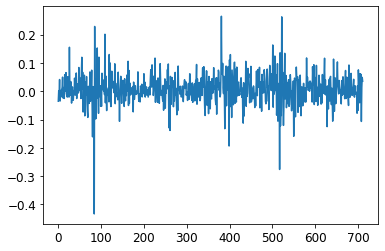

In [14]:
daily_eth['return'].plot()

In [18]:
daily_eth.to_csv('labeled_daily_eth.csv', header=True, index=False, mode='w')

In [17]:
slippage = (daily_eth['open'] - daily_eth['last_close']) / daily_eth['last_close']

In [22]:
# drop unnecessary col
drop_headers = ['low', 'high', 'close', 'volume', 'return', 'profit']
pruned_df = daily_eth.copy().drop(drop_headers, axis=1)

In [23]:
pruned_df = pruned_df[['time', 'last_low', 'last_high', 'last_open','last_close','last_volume', 'current_open', 'true_close']]

In [24]:
pruned_df['profit'] = ((pruned_df['last_open'] - pruned_df['last_close']) / pruned_df['last_open']) * pruned_df['trade'] * pruned_df['last_close'] 

In [25]:
pruned_df['profit'].sum()

3450.6248732426607

In [ ]:
pruned_df.to_csv('labeled_daily_eth_pruned.csv', header=True, index=False, mode='w')

In [ ]:
slippage.describe()

In [59]:
# split 80% training 20% test
m_samples = len(daily_eth)
m_train = int(m_samples * .8)
X_train = daily_eth.iloc[1:m_train , 1:]
#X_valid = daily_eth.iloc[m_train:, 1:]

array([[<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

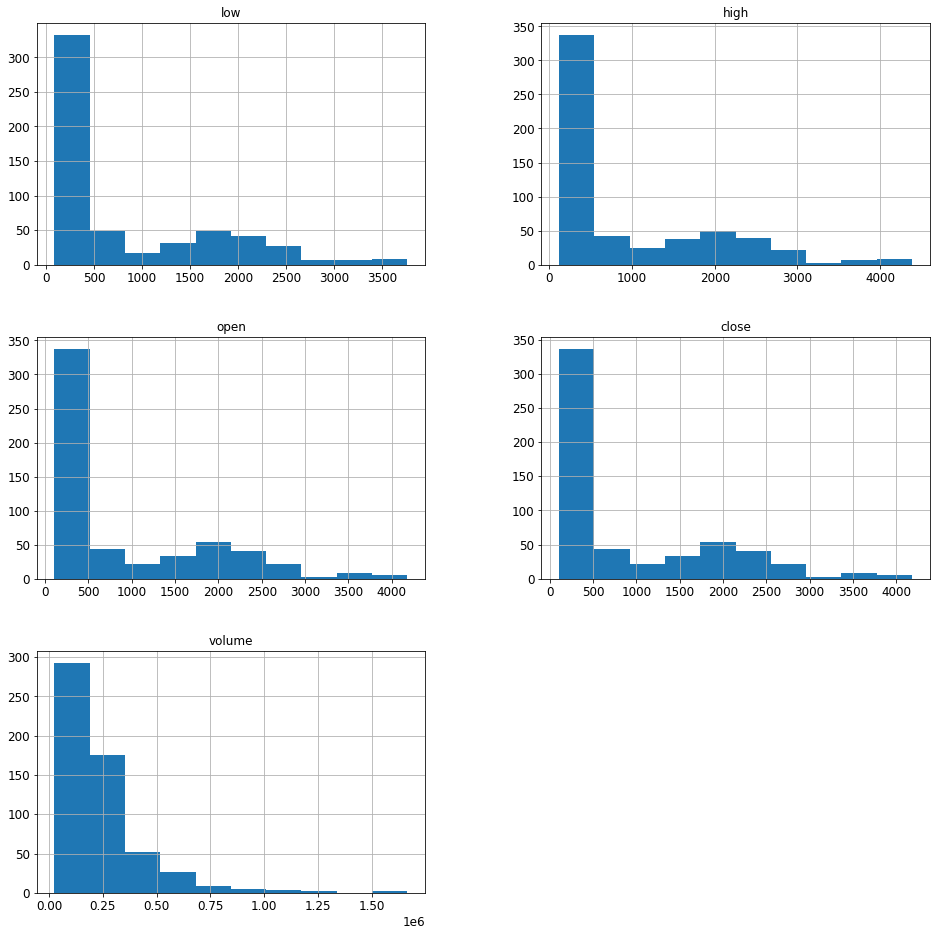

In [67]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

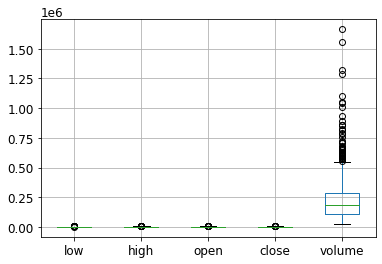

In [68]:
# very different range for each variable
X_train.boxplot()

In [69]:
X_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
low,568.0,845.62,875.17,90.00,217.48,376.32,1520.78,3760.00
high,568.0,932.44,979.97,118.88,230.84,399.71,1704.02,4384.43
open,568.0,892.42,933.09,110.30,224.83,387.66,1617.95,4179.77
close,568.0,895.98,934.02,110.30,224.98,387.93,1631.93,4179.76
volume,568.0,240719.91,205634.73,25941.74,112462.94,181311.36,287733.58,1664158.91


In [72]:
X_train = X_train.pct_change()
X_train = X_train.fillna(1)

In [73]:
X_valid = X_valid.pct_change()
X_valid = X_valid.fillna(1)

In [74]:
X_train.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
low,568.0,0.0085,0.0706,-0.4408,-0.0156,0.0105,0.0304,1.0000
high,568.0,0.0078,0.0619,-0.2435,-0.0162,-0.0006,0.0281,1.0000
open,568.0,0.0084,0.0707,-0.4333,-0.0205,0.0051,0.0354,1.0000
close,568.0,0.0084,0.0706,-0.4332,-0.0206,0.0055,0.0353,1.0000
volume,568.0,0.1434,0.6701,-0.7847,-0.2730,-0.0157,0.4128,5.1526


array([[<AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'high'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volume'}>, <AxesSubplot:>]],
      dtype=object)

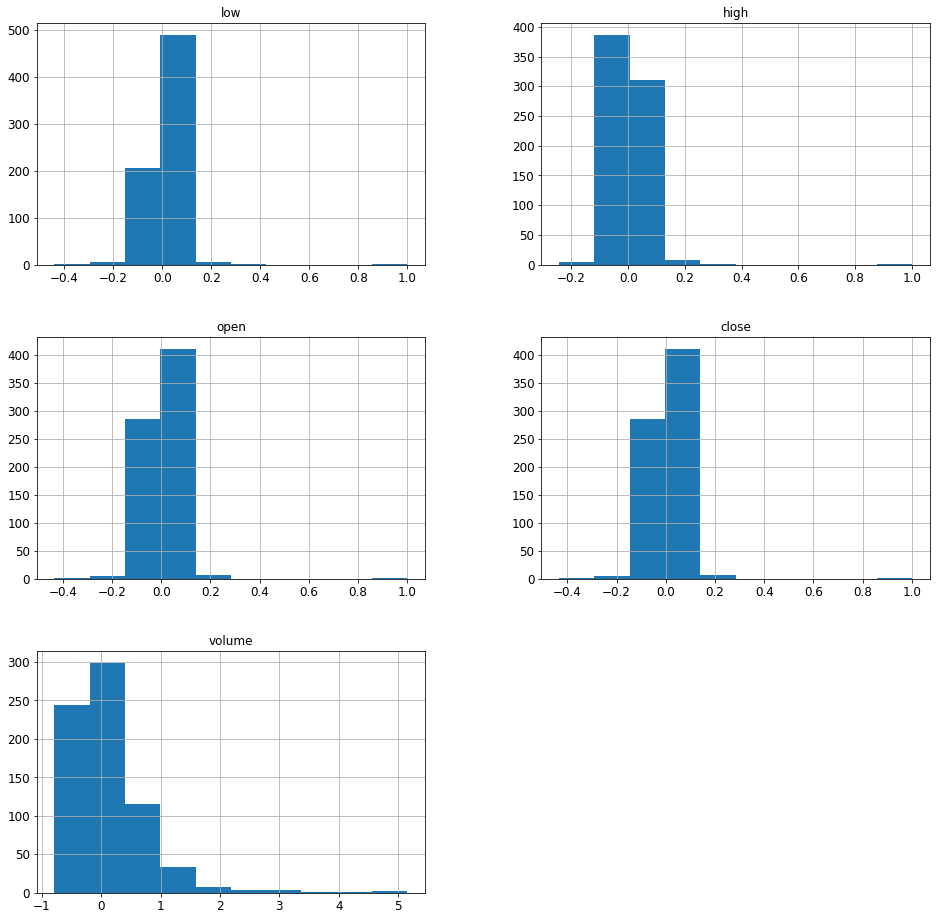

In [55]:
X_train.hist(figsize=(16, 16))

<AxesSubplot:>

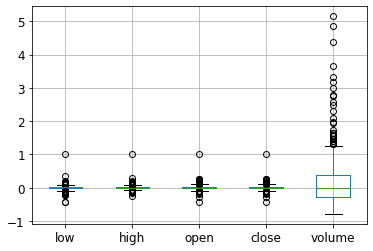

In [56]:
X_train.boxplot()

LTSM Autoencoder as feature detector
n Inputs must = n of Outputs
3 months - 90 days
input layer = 90 x 5 (low, high, open, close, vol)
hidden 1 = 32?
hidden 2 = 32?
output layer = 90 x 5

Building a recurrent autoencoder is straightforward: the encoder
is typically a sequence-to-vector RNN which compresses the input
sequence down to a single vector. The decoder is a vector-to-sequence RNN
that does the reverse:

In [88]:
n_features = 5 # (low, high, open, close, vol)
window_length = 90

# sequence-to-vector RNN
recurrent_encoder = keras.models.Sequential([
keras.layers.LSTM(100, return_sequences=True, input_shape=[None, n_features]),
keras.layers.LSTM(30)
])

# vector-to-sequence RNN
recurrent_decoder = keras.models.Sequential([
keras.layers.RepeatVector(n_features, input_shape=[30]),
keras.layers.LSTM(100, return_sequences=True),
keras.layers.TimeDistributed(keras.layers.Dense(n_features, activation="tanh"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_ae.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 30)                58120     
                                                                 
 sequential_14 (Sequential)  (None, 5, 5)              52905     
                                                                 
Total params: 111,025
Trainable params: 111,025
Non-trainable params: 0
_________________________________________________________________


In [89]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=['accuracy'])

In [92]:
# need to reshape X_train to 3D [batch size, time steps, n_features]
X_train.shape

(568, 5)

In [90]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10


ValueError: in user code:

    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/wsl/neural_network/neural_network/lib/python3.8/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_13" (type Sequential).
    
    Input 0 of layer "lstm_16" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 5)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
      • training=True
      • mask=None
